In [1]:
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

%matplotlib inline

In [2]:
user_table = pd.read_csv("/Users/kexinluo/Desktop/DS_take_home/6.Pricing_Test/user_table.csv")
user_table.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [3]:
user_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  275616 non-null  int64  
 1   city     275616 non-null  object 
 2   country  275616 non-null  object 
 3   lat      275616 non-null  float64
 4   long     275616 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


In [4]:
user_table.isnull().sum()

user_id    0
city       0
country    0
lat        0
long       0
dtype: int64

In [5]:
test_results = pd.read_csv('/Users/kexinluo/Desktop/DS_take_home/6.Pricing_Test/test_results.csv', parse_dates=['timestamp'])
test_results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [6]:
test_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           316800 non-null  int64 
 1   timestamp         316800 non-null  object
 2   source            316800 non-null  object
 3   device            316800 non-null  object
 4   operative_system  316800 non-null  object
 5   test              316800 non-null  int64 
 6   price             316800 non-null  int64 
 7   converted         316800 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


# Data Processing and Cleaning

In [7]:
# check uniquess
print('user_table:\t', user_table['user_id'].unique().shape)
print('test_results:\t', test_results['user_id'].unique().shape)

user_table:	 (275616,)
test_results:	 (316800,)


In [8]:
# merge test_results with user_table
data = pd.merge(left=test_results, right=user_table, how='left', on='user_id')
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [9]:
# Problem with the data: test and price not match
data[['price', 'test', 'user_id']].groupby(['test', 'price']).count()

user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918

It seems that there are some problems with the data

there are a small amount of users who are labelled with test=0 but actually see price 59
there are a small amount of users who are labelled with test=1 but actually see price 39.
Fortunately, they are only a very small portion of the whole dataset. The first step is to remove these problematic inputs.

In [10]:
# only keep the valid data
data = data[((data['test']==0) & (data['price']==39)) | ((data['test']==1) & (data['price']==59))]

In [11]:
# create new column called `revenue`
data['revenue'] = data['converted'] * data['price']

In [12]:
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,0


In [13]:
data.isnull().sum()

user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41141
country             41141
lat                 41141
long                41141
revenue                 0
dtype: int64

# Visualization

Now, let's check whether or not the test are totally randomized through simple visualization.

## 1. Source

In [14]:
# Check randominess
tmp = data.groupby('test')['source'].apply(lambda x: x.value_counts(normalize=True)).unstack()
tmp

,ads-bing,ads-google,ads-yahoo,ads_facebook,ads_other,direct_traffic,friend_referral,seo-bing,seo-google,seo-other,seo-yahoo,seo_facebook
test,,,,,,,,,,,,
0,0.072014,0.186873,0.023761,0.168253,0.095083,0.191154,0.064790,0.006562,0.074502,0.029030,0.021509,0.066468
1,0.072394,0.188706,0.024219,0.169253,0.092786,0.189259,0.066337,0.007154,0.070753,0.029539,0.021814,0.067786


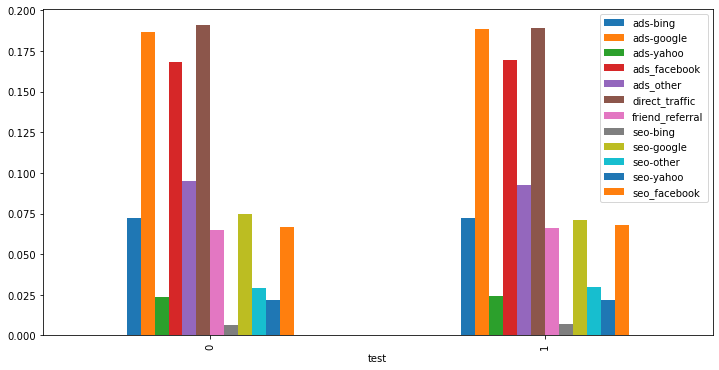

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
tmp.plot(kind='bar', ax=ax)
plt.show()

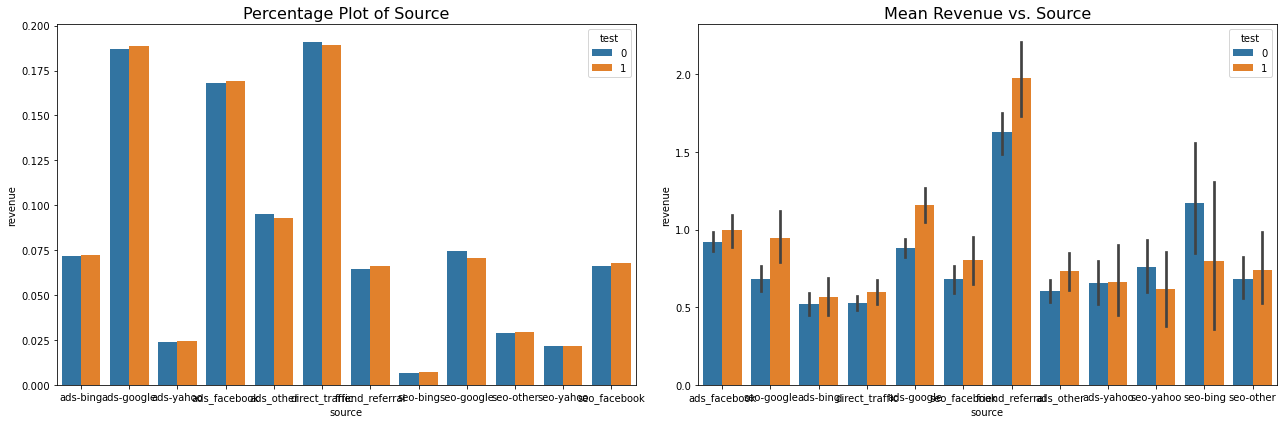

In [16]:
# Visualization of source
count = data[['source', 'test', 'revenue']].groupby(['source', 'test']).count().reset_index()
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='source', y='revenue', hue='test', data=count, ax=ax[0])
ax[0].set_title('Percentage Plot of Source', fontsize=16)

sns.barplot(x='source', y='revenue', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Revenue vs. Source', fontsize=16)
plt.tight_layout()
plt.show()

## 2. Device

In [17]:
# Check randominess
tmp = data.groupby('test')['device'].apply(lambda x: x.value_counts(normalize=True)).unstack()
tmp

,mobile,web
test,,
0,0.594365,0.405635
1,0.578469,0.421531


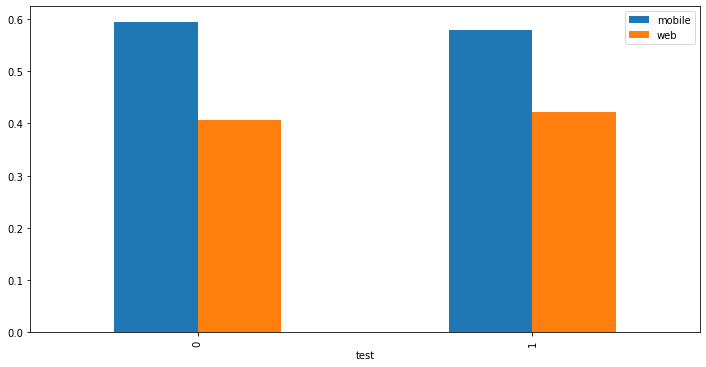

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
tmp.plot(kind='bar', ax=ax)
plt.show()

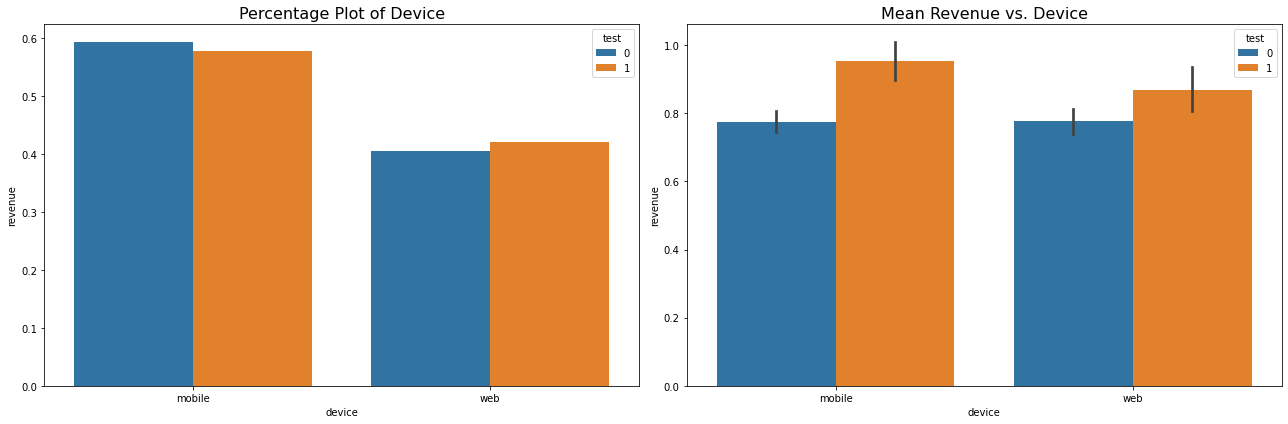

In [19]:
# Visualization of device
count = data[['device', 'test', 'revenue']].groupby(['device', 'test']).count().reset_index()
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='device', y='revenue', hue='test', data=count, ax=ax[0])
ax[0].set_title('Percentage Plot of Device', fontsize=16)

sns.barplot(x='device', y='revenue', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Revenue vs. Device', fontsize=16)
plt.tight_layout()
plt.show()

## 3. Operative System

In [20]:
# Check randominess
tmp = data.groupby('test')['operative_system'].apply(lambda x: x.value_counts(normalize=True)).unstack()
tmp

,windows,iOS,android,mac,other,linux
test,,,,,,
0,0.313638,0.305125,0.237891,0.080709,0.051754,0.010883
1,0.327718,0.294598,0.234318,0.076459,0.050001,0.016907


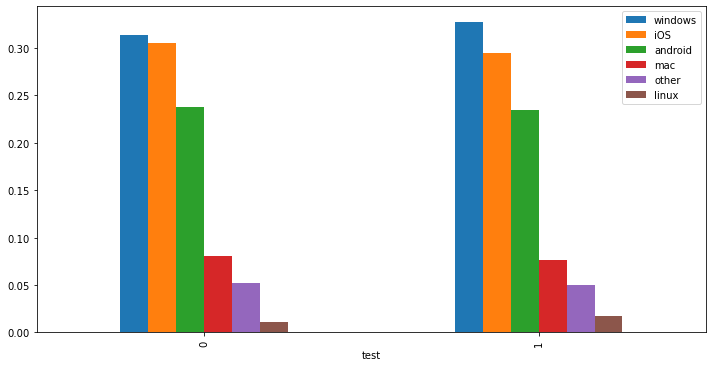

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
tmp.plot(kind='bar', ax=ax)
plt.show()

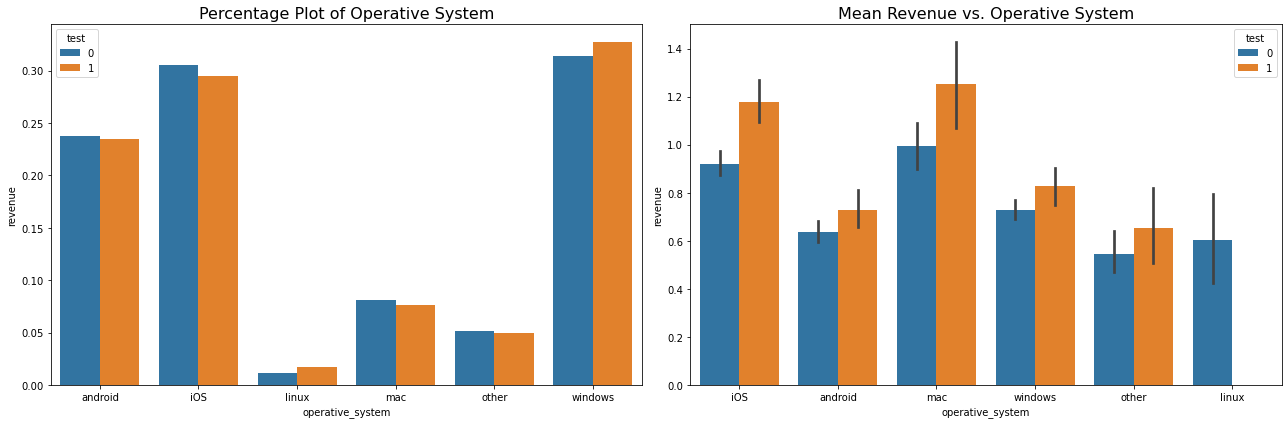

In [22]:
# Visualization of operative system
count = data[['operative_system', 'test', 'revenue']].groupby(['operative_system', 'test']).count().reset_index()
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='operative_system', y='revenue', hue='test', data=count, ax=ax[0])
ax[0].set_title('Percentage Plot of Operative System', fontsize=16)

sns.barplot(x='operative_system', y='revenue', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Revenue vs. Operative System', fontsize=16)
plt.tight_layout()
plt.show()

From above visualizations, we can see that the test is not  randomized, especially device and operative_system. These factors will influence the robostness of our final conclusions.

# Question 1

In [23]:
# check the conversion rate for A/B test
data[['test', 'converted']].groupby('test').mean()

,converted
test,
0,0.019900
1,0.015555


In [24]:
# check the revenue for A/B test
data[['test', 'revenue']].groupby('test').mean()

,revenue
test,
0,0.776083
1,0.917748


Clearly, for those with lower price $39, they have a higher conversion rate 1.99\%. For those with higher price $59, the conversion rate is 1.556\%. However, considering the price, the average revenue for higher price (0.917) is actually larger than the lower price (0.776).

Now, let's conduct hypothesis testing.
- Null hypothesis H0: experimental group's average revenue is equal to or less than control group's average revenue
- Alternative hypothesis H1: experimental group's average revenue is higher than control group's average revenue

In [25]:
ctr_val = data[data['test'] == 0]['revenue'].values
exp_val = data[data['test'] == 1]['revenue'].values
print(ttest_ind(ctr_val, exp_val, axis=0, equal_var=False))

Ttest_indResult(statistic=-5.715224666463108, pvalue=1.0972577312420781e-08)


The above test is actually two tailed test. What we want is one-tailed test. However, from above result, we can easily conclude that even for one-tailed test, we can safely conclude that we can reject the null hypothesis, and conclude that experimental group's average revenue is higher than control group's average revenue.

Although our test suggest that $59 price can give us higher average revenue. However, due to the problem with the A/B test, the above result is not scientifically accurate. More scientific A/B test is needed.

# Question 2

## 1. Source

In [26]:
data.groupby('source')['converted'].mean().reset_index()

,source,converted
0,ads-bing,0.012001
1,ads-google,0.021502
2,ads-yahoo,0.014793
3,ads_facebook,0.021198
4,ads_other,0.014350
5,direct_traffic,0.012294
6,friend_referral,0.038688
7,seo-bing,0.023787
8,seo-google,0.016978
9,seo-other,0.015686


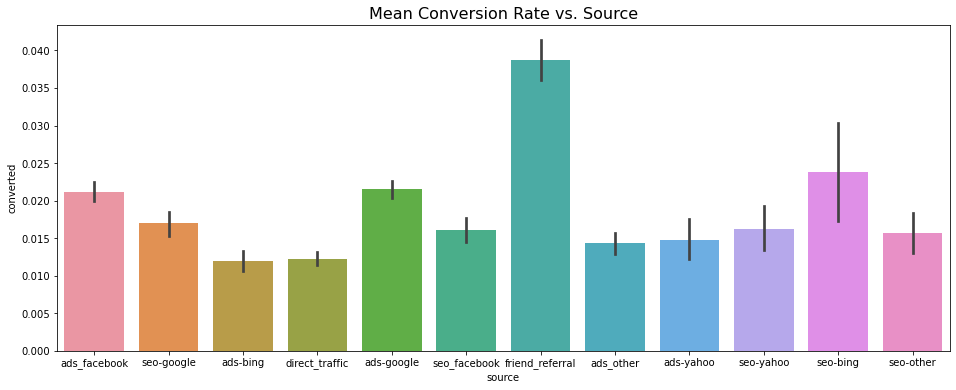

In [27]:
# Visualization of source
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='source', y='converted', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Source', fontsize=16)
plt.show()

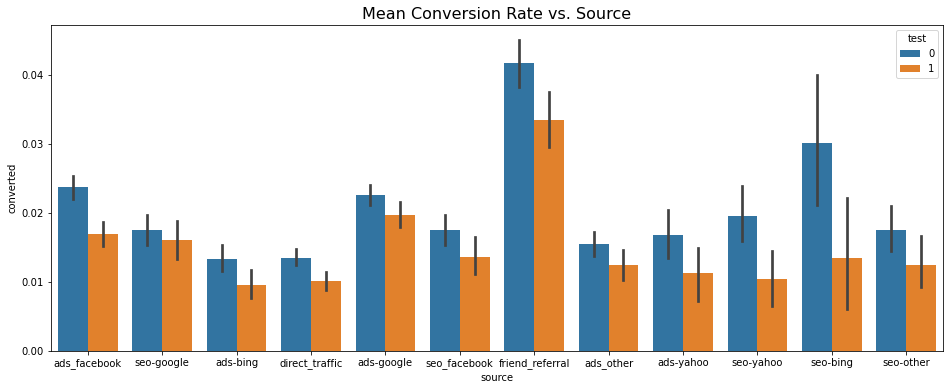

In [28]:
# Visualization of source
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='source', y='converted', hue='test', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Source', fontsize=16)
plt.show()

## 2. Device

In [29]:
data.groupby('device')['converted'].mean().reset_index()

,device,converted
0,mobile,0.018554
1,web,0.018023


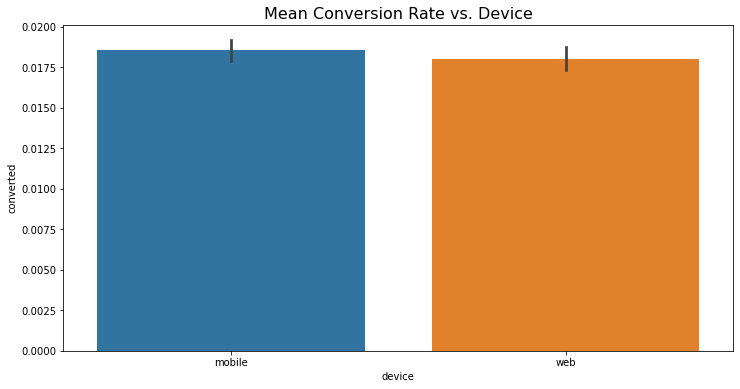

In [30]:
# Visualization of device
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='device', y='converted', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Device', fontsize=16)
plt.show()

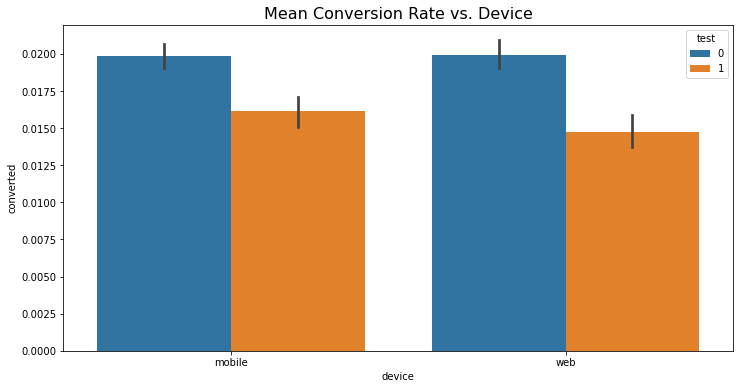

In [31]:
# Visualization of device
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='device', y='converted', hue='test', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Device', fontsize=16)
plt.show()

## 3. Operative System

In [32]:
data.groupby('operative_system')['converted'].mean().reset_index()

,operative_system,converted
0,android,0.014919
1,iOS,0.022328
2,linux,0.008232
3,mac,0.023987
4,other,0.012981
5,windows,0.016966


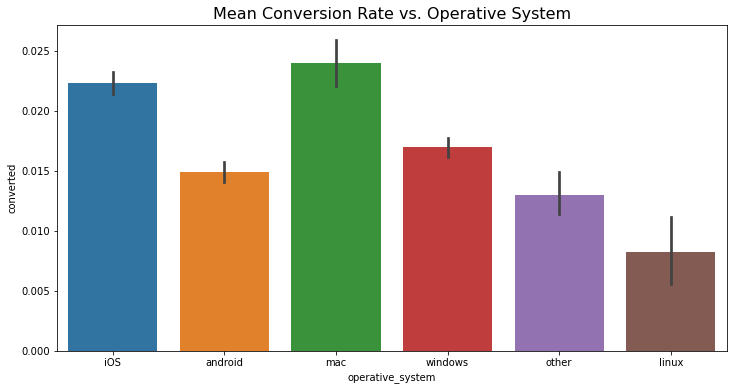

In [33]:
# Visualization of operative system
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='operative_system', y='converted', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Operative System', fontsize=16)
plt.show()

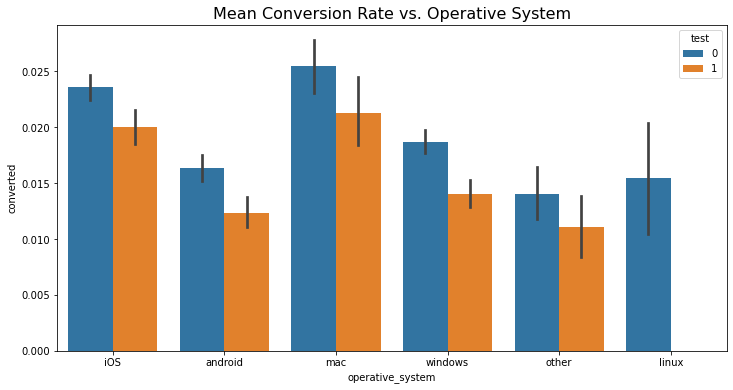

In [34]:
# Visualization of operative system
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='operative_system', y='converted', hue='test', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Operative System', fontsize=16)
plt.show()

From above visualizations, we can easily conclude that price dramatically influence the conversion rate. But beside price, there are still other factors that can influence the conversion rate.

- Source
 - Friend-referral users have much higher conversion rate
- Device
 - The influence of device is not significant
- Operative System
 - Mac and ios users have much higher conversion rate

## Actionable Insights (refer to online resource)

friend_referral, Apple user (MAC or iOS), low price are three great positive factors which improve the conversion rate if we want to increase the price, which impacts negatively on conversion rate, we must compensate on the other two factors

